# Turing.jl とOptim.jlで分位数から分布パラメータを推定する

## モチベーション
**※本記事は以前の記事の誤りを訂正するものである。あの記事は問題と誤解がある。**
データ分析で分布を調べることは基礎的な手順のひとつであるが、1次データが常に手に入るとは限らない。特に調査会社のレポートはRAWデータなしの分位数データしか手に入らないことも多いはず。分位数のデータから分布を予測する方法をメモ代わりに記しておきたい。

## パッケージインストールとデータ読み込み

In [2]:
using Distributions,StatsPlots,Statistics,DataFrames,CSV
using Turing,Optim

## 分位数から分布を調べるとは？

まずはToyモデルで今回の課題を具体的に理解する。通常は1次データ（RAWデータ）を観測された（Observed）サンプルから分布を推計する。

In [3]:
ss = rand(Normal(2.3,1.3),200);

In [4]:
quantile(ss)

5-element Vector{Float64}:
 -1.6620928884325774
  1.6886897070619513
  2.6915429779901996
  3.5889345513609996
  5.753409614850915

In [5]:
@model function demo(xs)
    m ~ Normal(0,3)
    s ~ InverseGamma(2,3)
    xs .~ Normal(m,s)
end

demo (generic function with 2 methods)

In [6]:
ctest = sample(demo(ss),NUTS(),3000,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 12.99 seconds
Compute duration  = 12.99 seconds
parameters        = m, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           m    2.6134    0.0970    0.0017   3436.1304   2099.5825    1.0009   ⋯
           s    1.3699    0.0680    0.0012   3063.9120   2298.8531    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        

もしくはもっと簡単にfit, fit_mleを使えばよい。

In [7]:
fit_mle(Normal,ss)

Normal{Float64}(μ=2.619556009745499, σ=1.35994731337177)

しかし入手できるデータが次のような分位数（quantile)データだけの場合がある。

In [9]:
qs = [0.25,0.5,0.75,0.95]
xs = quantile(ss,qs)
DataFrame( :Quantile => qs, :X => xs )

Row,Quantile,X
,Float64,Float64
1,0.25,1.68869
2,0.5,2.69154
3,0.75,3.58893
4,0.95,4.80957


分位数から分布のパラメーターを調べるモデルは次のようになる

In [11]:
@model function q_demo(xs,qs)
    m ~ Normal(0,3)
    s ~ InverseGamma(2,3)
    o ~ Exponential(1)
    dist = Normal(m,s)
    xs .~ arraydist( [ Normal(quantile(dist,q),o) for q in qs] )
end
qtest = sample(q_demo(xs,qs),NUTS(),3000,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


Chains MCMC chain (3000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 10.96 seconds
Compute duration  = 10.96 seconds
parameters        = m, s, o
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           m    2.6420    0.1409    0.0059   878.1350   533.6514    1.0005     ⋯
           s    1.3239    0.1345    0.0060   604.2489   370.5527    1.0005     ⋯
           o    0.1769    0.1794    0.0124   129.2869    99.3621    1.0008     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0% 

あるいはこういう書き方も可能。

理想的な分布を探せるケースはほとんどない。現実はモデルにfitしないのである

In [12]:
m = get(qtest,[:m,:s]).m |> mean
s = get(qtest,[:m,:s]).s |> mean
(;m=m,s=s)

(m = 2.641982235351597, s = 1.3239343646448969)

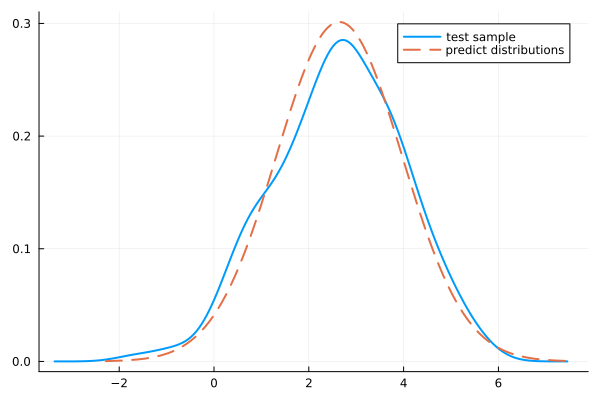

In [13]:
density(ss,lw=2,label="test sample")
plot!(Normal(m,s),lw=2,ls=:dash,label="predict distributions")

モデルが正しく推定できたことを確認できたので、実際の問題を解決してみよう。

## マラソン大会の人員手配を考える
[北海道マラソン](https://hokkaido-marathon.com/)がもうすぐ開催されるので、これを事例にしてみる。出展ブースで完走者全員に記念品を手渡したい。ランナーたちはスタートから2時間～6時間で到着する。スタッフを雇う時間は限られているので、ランナーがもっとも多くゴールする時間帯にあわせてスタッフの人数と配置を考えたい。もっとも多くのランナーが到着するのはスタートから何分ごろと考えるべきだろうか？

北海道マラソン運営は[完走タイム別人数分布表](https://hokkaido-marathon.com/data/distribution/)を公開している。残念ながらRAWデータではなく、スタートから2時間から4時間までの10分刻みの完走人数と4～5時間のランナーはひとつの区分で表示している。発表データを以下の表に転記する。最終ランナーの締め切りは300分（5時間）として設定した。（2019年大会は制限時間5時間でしたが、2022年大会は制限時間が6時間になったようです）

|タイム（分）|男子|女子|合計
|--------|-----|-----|-----|
|～140|29  |  0|   29|
|141～150|	25|	0|	25|
|151～160|	83|	5|	88|
|161～170| 127 |	7|134
|171～180| 281 |	11|292
|181～190| 268 |	26 |294
|191～200| 470 | 36 |506
|201～210|	648|	60	|708
|211～220|	697|	86	|783
|221～230|	818|	117	|935
|231～240|	1112|	180|	1292
|241～300|6779|	1592|8371

## データ読み込み

興味の対象はランナー合計なので性別のデータは削除する。北海道マラソン2019の参加者は公式で15,932人と発表されている。制限時間にゴールした人は13,457人なので2475人が制限時間の5時間に間に合っていない。この点を考慮し分布データから分位数を算出する。

In [14]:
df = CSV.read("hokkaido-marason.csv",DataFrame)
df.ac_male = accumulate(+, df[:,:male])
df.ac_female = accumulate(+, df[:,:female])
df.percentile_male = df.ac_male ./ sum(df.male)
df.percentile_female = df.ac_female ./ sum(df.female)
df

Row,goal_time,male,female,runner,ac_male,ac_female,percentile_male,percentile_female
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,140,29,0,29,29,0,0.002558,0.0
2,150,25,0,25,54,0,0.00476316,0.0
3,160,83,5,88,137,5,0.0120843,0.00235849
4,170,127,7,134,264,12,0.0232866,0.00566038
5,180,281,11,292,545,23,0.0480727,0.0108491
6,190,268,26,294,813,49,0.0717121,0.0231132
7,200,470,36,506,1283,85,0.113169,0.0400943
8,210,648,60,708,1931,145,0.170327,0.0683962
9,220,697,86,783,2628,231,0.231807,0.108962


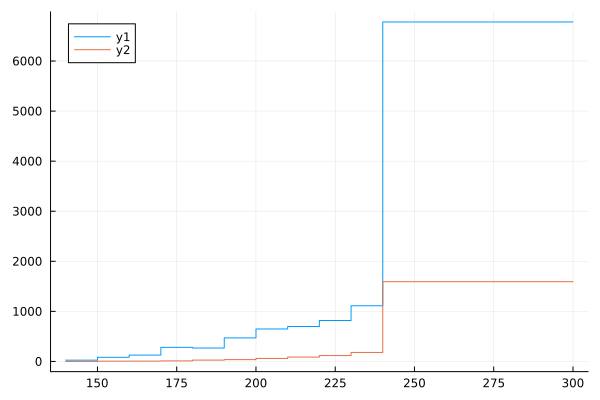

In [15]:
@df df plot(st=:steppre,:goal_time,[:male,:female])

StasPlotsのEqual-area histogramsでゴールタイムの分布を確認する。300分以上のランナーが2475人いることも忘れずに241分～360分までのデータが喪失しているがNormal Distributionsでよさそうだ。

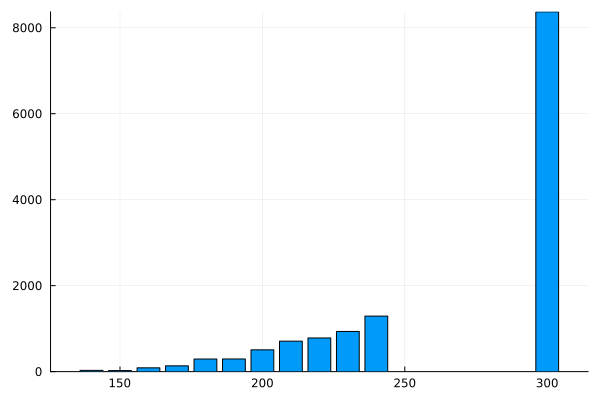

In [16]:
@df df plot(:goal_time,:runner,st=:bar,label="")

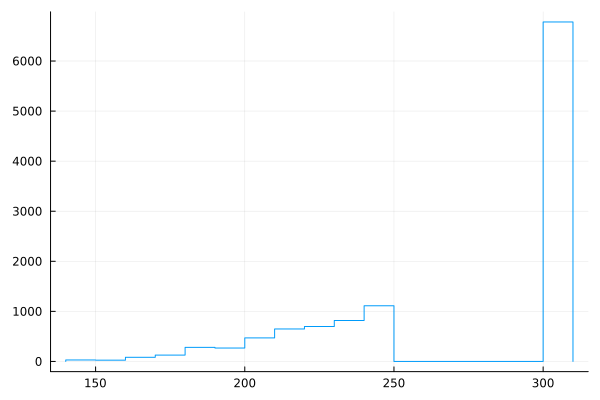

In [17]:
a = [fill(e[1],e[2]) for e in eachrow(df)] |> t-> vcat(t...)
#histogram(a)
#ea_histogram(a, fillalpha = 0.4,label="")
plot(a,st=:stephist, label="")
#plot!(a,st=:bar, label="")

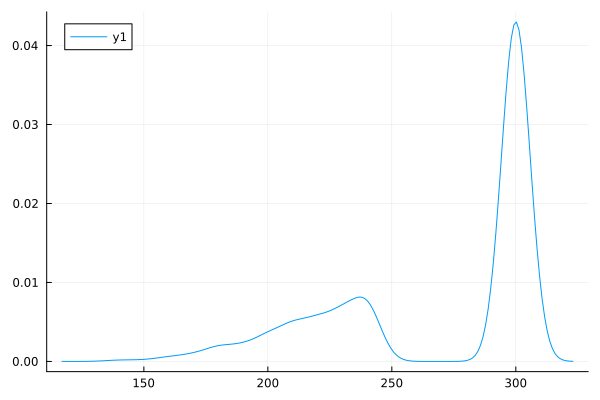

In [18]:
v = [fill(df[i,:goal_time],df[i,:runner]) for i =1:12] |> t -> vcat(t...)
density(v)

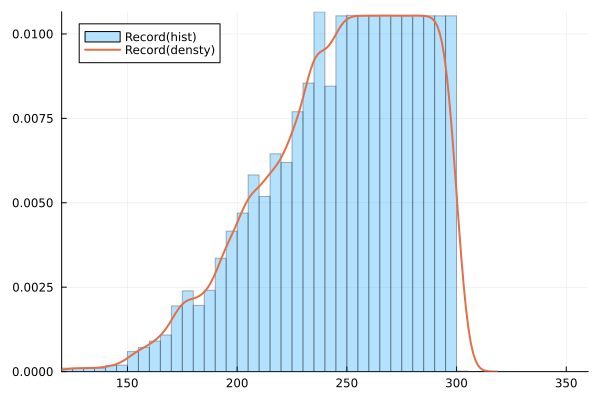

In [19]:
#mean_time = [140,145,155,165,175,185,195,205,215,225,235,300]
mean_f = [120,141,151,161,171,181,191,201,211,221,231,241,301]
mean_t = [140,150,160,170,180,190,200,210,220,230,240,300,420]
mean_record = [collect(range(mean_f[i],mean_t[i] ; length=df[i,:runner])) for i = 1:12]  |> t -> vcat(t...)
histogram(mean_record,normalize=:pdf,label="Record(hist)",xlims=(120,360),alpha=0.3)
density!(mean_record,label="Record(densty)",lw=2,legend=:topleft)

In [20]:
savefig("hokkaido-M_record.png")

"/Users/kimseok/GitHub/Hokkaido_Marathon/hokkaido-M_record.png"

## 分位数データから分布パラメータを推定する

In [21]:
@model function findfromquantile(tim,acc)
    μ ~ Normal(0,10)
    σ ~ InverseGamma(2,3)
    s ~ Exponential(1)

    dist = Normal(μ,σ)
    tim .~ arraydist([Normal(quantile(dist,q),0.1) for q in acc])
end

findfromquantile (generic function with 2 methods)

分位数100％はパラメタ推定にとって無意味(Infを探してしまう）なので除いてモデルに渡す。

In [22]:
df

Row,goal_time,male,female,runner,ac_male,ac_female,percentile_male,percentile_female
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,140,29,0,29,29,0,0.002558,0.0
2,150,25,0,25,54,0,0.00476316,0.0
3,160,83,5,88,137,5,0.0120843,0.00235849
4,170,127,7,134,264,12,0.0232866,0.00566038
5,180,281,11,292,545,23,0.0480727,0.0108491
6,190,268,26,294,813,49,0.0717121,0.0231132
7,200,470,36,506,1283,85,0.113169,0.0400943
8,210,648,60,708,1931,145,0.170327,0.0683962
9,220,697,86,783,2628,231,0.231807,0.108962


In [27]:
times =df[1:(end-1), :goal_time] 
quant =df[1:(end-1), :percentile_male];

In [28]:
model = findfromquantile(times,quant)
c_quantile = sample(model,NUTS(),3000, progress=false)

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


Chains MCMC chain (3000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 1.86 seconds
Compute duration  = 1.86 seconds
parameters        = μ, σ, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

           μ   248.1255    0.0612    0.0018   1160.6027   1253.8034    0.9997  ⋯
           σ    38.9390    0.0365    0.0010   1316.2028   1508.6432    1.0002  ⋯
           s     0.9630    1.0063    0.0236   1068.8683    868.6383    1.0008  ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0

In [29]:
summary_report, quantile_report = describe(c_quantile[:,[:μ,:σ],:])
summary_report

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

           μ   248.1255    0.0612    0.0018   1160.6027   1253.8034    0.9997  ⋯
           σ    38.9390    0.0365    0.0010   1316.2028   1508.6432    1.0002  ⋯
                                                                1 column omitted


In [30]:
quantile_report

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           μ   248.0052   248.0841   248.1260   248.1682   248.2446
           σ    38.8674    38.9149    38.9393    38.9639    39.0097


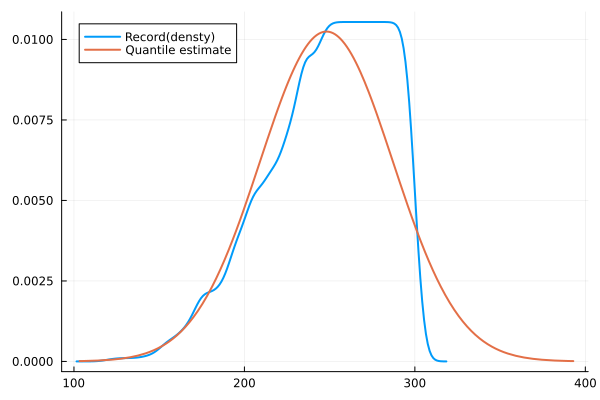

In [31]:
m_1 = get(c_quantile,[:μ]).μ |> mean
o_1 = get(c_quantile,[:σ]).σ |> mean
quantile_est_dist = Normal(m_1,o_1)

density(mean_record,label="Record(densty)",lw=2,legend=:topleft)
plot!(quantile_est_dist,lw=2,label="Quantile estimate")

In [32]:
savefig("quantile-estimate.png")

"/Users/kimseok/GitHub/Hokkaido_Marathon/quantile-estimate.png"

In [33]:
model = findfromquantile(times,quant)

DynamicPPL.Model{typeof(findfromquantile), (:tim, :acc), (), (), Tuple{Vector{Int64}, Vector{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(findfromquantile, (tim = [140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240], acc = [0.0025579959424891947, 0.004763164858428155, 0.012084325659345505, 0.02328658375231543, 0.048072682367469345, 0.071712093146335, 0.11316926876598747, 0.17032724706712535, 0.23180735644350356, 0.3039604833730264, 0.40204639675399134]), NamedTuple(), DynamicPPL.DefaultContext())

In [38]:
opt_normal=optimize(model,MLE(),NelderMead())

ModeResult with maximized lp of -549984.78
[190.00000280054203, 3.5116718013513966e-8, 0.00016735775865060117]

In [39]:
c_opt = sample(model,NUTS(),3000,init_params = opt_normal.values.array, progress=false)

┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


Chains MCMC chain (3000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 16.11 seconds
Compute duration  = 16.11 seconds
parameters        = μ, σ, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

           μ   248.1224    0.0659    0.0017   1469.3159   1184.5334    0.9997  ⋯
           σ    38.9381    0.0384    0.0009   1660.4147   1579.2258    1.0000  ⋯
           s     0.0002    0.0001    0.0000      9.7598     17.2157    1.1939  ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75

推定した分布をもとにサンプリングして実際の記録値と比較してみる

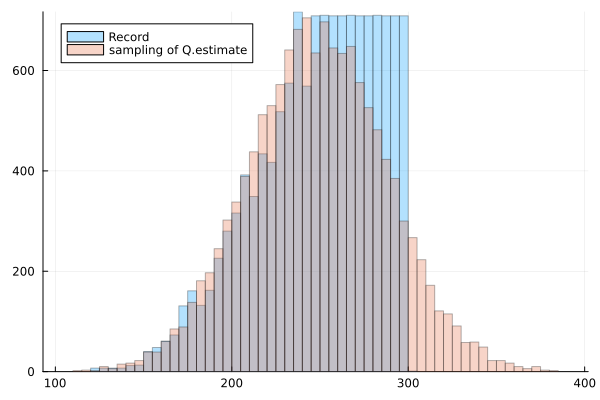

In [40]:
histogram(mean_record,label="Record",legend=:topleft,alpha=0.3)
histogram!(rand(quantile_est_dist,length(mean_record)),label="sampling of Q.estimate",alpha=0.3)

In [41]:
df.normal_cdf=cdf(quantile_est_dist, df[:,:goal_time])
df

Row,goal_time,male,female,runner,ac_male,ac_female,percentile_male,percentile_female,normal_cdf
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,140,29,0,29,29,0,0.002558,0.0,0.00274491
2,150,25,0,25,54,0,0.00476316,0.0,0.00586806
3,160,83,5,88,137,5,0.0120843,0.00235849,0.0118126
4,170,127,7,134,264,12,0.0232866,0.00566038,0.0224091
5,180,281,11,292,545,23,0.0480727,0.0108491,0.0400984
6,190,268,26,294,813,49,0.0717121,0.0231132,0.0677535
7,200,470,36,506,1283,85,0.113169,0.0400943,0.108244
8,210,648,60,708,1931,145,0.170327,0.0683962,0.163763
9,220,697,86,783,2628,231,0.231807,0.108962,0.235056


### やや外れた感がある。標準分布を想定したことは間違いだろうか？

おそらく分布としては標準分布よりGamma分布のほうがモデルとして適しているかもしれない。なぜならGamma分布はそれぞれ独立した事象の到着時間を表す分布だから、マラソンのゴール時間を表現するには適していると思われるからだ。しかし実はJuliaのgamma関数が自動微分をサポートしないためTuringでGamma分布やGamma関数を扱うには制限がある。実際前項で示した分位数から推定する方法がGamma分布ではエラーになってしまう。したがってGamma分布を調べるためにはサンプリングから分布を調べる方法しか思いつかない。

## サンプリングデータからGamma分布を調べる
分位数データに沿ってサンプルを作成し、MCMCでパラメータを調べる。この方法の最大の欠点は、データレコードの一部があいまいなため（〇〇時間以上など）、ご都合な仮定（同幅の時間に選手が返ってくる）を採用せざるを得ずデータ喪失が行われるので注意しなければならない。

In [45]:
@model function one_gamma_param(xs,qs)
    a ~ InverseGamma(2,3)
    b ~ InverseGamma(2,3)
    s ~ Exponential(1)
    dist=Gamma(a,b)
    xs .~ arraydist([Normal( quantile(dist, q) , sqrt(s) ) for q in qs])     
end

one_gamma_param (generic function with 2 methods)

In [54]:
times =df[1:(end-1), :goal_time] 
quant =df[1:(end-1), :percentile_male];

model = one_gamma_param(times,quant)
opt_model = optimize(model,MAP(),NelderMead())

ModeResult with maximized lp of -29.35
[28.350476856110966, 9.026227708831506, 0.8809289492690225]

In [55]:
sample(model,PG(10),3000,init_params=opt_model.values.array , progress=false)

Chains MCMC chain (3000×5×1 Array{Float64, 3}):

Log evidence      = 0.0
Iterations        = 1:1:3000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 99.52 seconds
Compute duration  = 99.52 seconds
parameters        = a, b, s
internals         = lp, logevidence

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           a    3.0851    4.5831    0.0968   2347.3325   2262.6511    0.9998   ⋯
           b    2.9766    5.4982    0.1099   2420.6662   2377.3602    0.9998   ⋯
           s    0.9985    1.0286    0.0208   2355.1991   2263.3005    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           a    0.5484    1.1214    1.8239    3.2320   14.3113
         

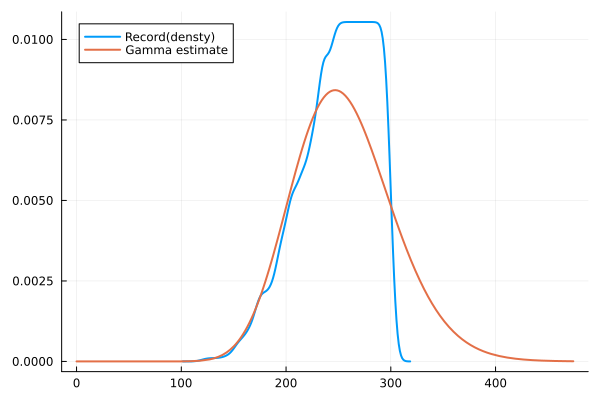

In [56]:
gdist=Gamma(opt_model.values.array[1],opt_model.values.array[2])
density(mean_record,label="Record(densty)",lw=2,legend=:topleft)
#plot!(quantile_est_dist,lw=2,label="Normal estimate")
plot!(gdist,lw=2,label="Gamma estimate")
#histogram(mean_record,label="Record",legend=:topleft,alpha=0.3)
#sample_dist = Gamma(a_1,b_1)
#histogram!(rand(sample_dist,length(mean_record)),label="sampling estimate",alpha=0.3)

In [51]:
#savefig("sample-estimate.png")

サンプリングデータから推定した分布パラメータが実際の測定値とどれくらい乖離があるかを比較する。231分～240分では9％の差がありうまく表現できてるといえない結果となった。

In [57]:
df.gamma_cdf=cdf(gdist,df[:,:goal_time]);df

Row,goal_time,male,female,runner,ac_male,ac_female,percentile_male,percentile_female,normal_cdf,gamma_cdf
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,140,29,0,29,29,0,0.002558,0.0,0.00274491,0.00216436
2,150,25,0,25,54,0,0.00476316,0.0,0.00586806,0.00543675
3,160,83,5,88,137,5,0.0120843,0.00235849,0.0118126,0.0120904
4,170,127,7,134,264,12,0.0232866,0.00566038,0.0224091,0.0241817
5,180,281,11,292,545,23,0.0480727,0.0108491,0.0400984,0.0440762
6,190,268,26,294,813,49,0.0717121,0.0231132,0.0677535,0.074038
7,200,470,36,506,1283,85,0.113169,0.0400943,0.108244,0.115722
8,210,648,60,708,1931,145,0.170327,0.0683962,0.163763,0.169714
9,220,697,86,783,2628,231,0.231807,0.108962,0.235056,0.235266


In [58]:
msce_func(xs,ys) = ( xs .- ys ) .^ 2 |> sum |> sqrt 
msce_func(df.percentile_male, df.normal_cdf), msce_func(df.percentile_male, df.gamma_cdf)

(0.09502801352660427, 0.17634276106922386)

In [59]:
using ForwardDiff,StatsFuns,SpecialFunctions

In [60]:
function SpecialFunctions.__gamma_inc_inv(a::ForwardDiff.Dual{T}, minpq::ForwardDiff.Dual{T}, pcase::Bool) where {T}
    
    v_a= ForwardDiff.value(a)
    v_pq = ForwardDiff.value(minpq)
    p_a = ForwardDiff.partials(a).values
    p_pq = ForwardDiff.partials(minpq).values

    SpecialFunctions.__gamma_inc_inv(v_a,v_pq,pcase)
end

In [61]:
@model function gamma_quantile_find(tim,acc)
    n = length(tim)
     k ~ InverseGamma(2,3)
    θ ~ InverseGamma(2,3)
     s ~ Truncated(Normal(0,3),0,10)
   
    dist = Gamma(k,θ)
    
    q = Vector{Any}(undef,length(acc))
    for i = 1:n
        q[i] ~ Normal(quantile(dist,acc[i]),s)
        q[i] ~ Normal(tim[i],s)    
    end
end   

gamma_quantile_find (generic function with 2 methods)

In [63]:
times =df[1:(end-1), :goal_time] 
quant =df[1:(end-1), :percentile_male];

model = gamma_quantile_find(times, quant)
g_quantile = sample(model,NUTS(),3000,progress=false)

In [90]:
params = get(g_quantile,[:k,:θ])
k = params.k |> mean
θ = params.θ |> mean

8.401339609774825

In [91]:
k_conf = get(g_quantile,[:k]).k |> vec |>  t->quantile(t,[0.025,0.975])
th_conf = get(g_quantile,[:θ]).θ |> vec |>  t->quantile(t,[0.025,0.975])
conf_min, conf_max = (mean(Gamma(k_conf[1],th_conf[1])),mean(Gamma(k_conf[2],th_conf[2])))

(212.67231688492328, 317.76191137815414)

In [92]:
mus = get(c_quantile,[:μ,:σ]).μ |> vec |> t->quantile(t,[0.025,0.975])
sigs = get(c_quantile,[:μ,:σ]).σ |> vec |> t->quantile(t,[0.025,0.975])
nor_max = maximum(mus) + 2*maximum(sigs)
nor_min = minimum(mus) - 2*maximum(sigs)

175.3171292935337

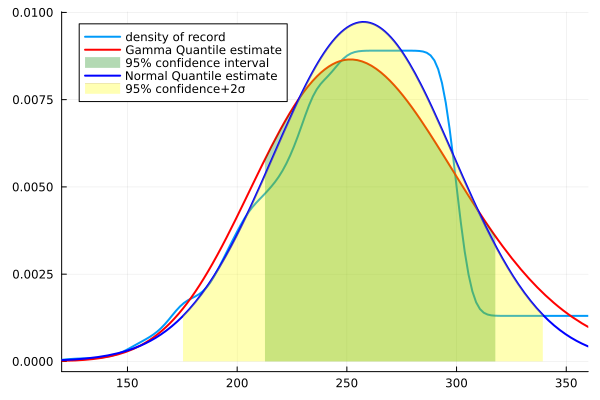

In [93]:
density(mean_record,lw=2,label="density of record",legend=:topleft,xlims=(120,360))
plot!(Gamma(k,θ),lw=2,label="Gamma Quantile estimate",color=:red)
plot!(Gamma(k,θ),conf_min:conf_max,fill5
4lw=0,label="95% confidence interval")
plot!(quantile_est_dist,lw=2,label="Normal Quantile estimate",color=:blue)
plot!(quantile_est_dist,nor_min:nor_max,fill=(0,0.3,:yellow),lw=0,label="95% confidence+2σ")
#vline!([mean(quantile_est_dist),mean(Gamma(k,θ))],ls=:dash,label="mean of dist")

In [94]:
savefig("marathon-3graph.png")

"C:\\Users\\kimse\\OneDrive\\Jupyter_notebook\\北海道マラソンのタイム推計\\marathon-3graph.png"

In [95]:
df.run_gamma_quantile=cdf(Gamma(k,θ),df[:,:goal_time]);df[:,4:end]

Row,完走累積分位,normal_cdf,gamma_cdf,run_gamma_quantile
,Float64,Float64,Float64,Float64
1,0.00182024,0.00207846,0.00111063,0.00110338
2,0.0033894,0.00436793,0.00308077,0.00305109
3,0.00891288,0.00869301,0.00747194,0.00738273
4,0.0173236,0.0163944,0.0161215,0.0159027
5,0.0356515,0.0293201,0.0313947,0.0309355
6,0.0541049,0.0497687,0.0558612,0.0550131
7,0.0858649,0.0802606,0.0917788,0.0903732
8,0.130304,0.123118,0.140518,0.138397
9,0.17945,0.179896,0.202105,0.199162


In [96]:
mean(Gamma(k,θ))

260.0556377441261

parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           k    29.8842    30.8678    31.3752    31.9094    33.0545
           θ     7.8122     8.0934     8.2521     8.4085     8.7225

In [97]:
mean(Gamma(29.8842,7.8122))

233.46134723999998

In [98]:
mean(Gamma(33.0545,8.7225))

288.31787625